In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
count = 0
for _, _, filenames in os.walk('/kaggle/input'):
    count += len(filenames)

print(f"Toplam dosya sayısı: {count}")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Toplam dosya sayısı: 7023


In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D,Flatten,Dense,Dropout,Input)

2026-01-13 13:55:54.078736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768312554.601285      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768312554.765336      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768312555.921548      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768312555.921614      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768312555.921616      55 computation_placer.cc:177] computation placer alr

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# ImageDataGenerator (preprocessing,augmentation,label encoding yapar)
# bu sınıf dataset RAM'e sığmadığında kullanılır

## Sıralama:

* Split: Veriyi Eğitim (%80) ve Test (%20) olarak ayır.(veri zaten ayrılmış)

* Preprocessing: Eğitim setinin istatistiklerine göre (boyutlandırma, parlaklık ayarı vb.) her iki seti de işle.

In [6]:
base_dir = '/kaggle/input/brain-tumor-mri-dataset'
train_dir = os.path.join(base_dir,'Training')
test_dir = os.path.join(base_dir,'Testing')

## Augmentation
* Eldeki veri sabittir -> model bu veriyi ezberlemeye meyillidir.
* Augmentation : Aynı görününtün etiketi değişmeden farklı versiyonlarını üretir
* Ama diskte yeni dosya oluşturmaz her epoch'ta anlık (on-the-fly) yapılır
  

In [7]:
# Preprocessing ve Augmentation ayarları
train_datagen = ImageDataGenerator(
    rescale = 1./255, # [0,255] -> [0,1] piksel değeri
    rotation_range = 20, # modelin açıya ezber yapmasını engeller
    horizontal_flip= True, # ? çıkarılabilir
    validation_split= 0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [8]:
# verileri akış (flow) halinde yükleme
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

# bunu sileyim mi
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle = False  #Ölçüm yaparken asla karıştırma
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224,224),
    batch_size = 32,
    class_mode='categorical',
    subset='validation'
)

Found 4571 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Found 1141 images belonging to 4 classes.


In [9]:


def count_images_per_class(base_path):
    class_counts = {}
    for class_name in sorted(os.listdir(base_path)):
        class_path = os.path.join(base_path, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len([
                f for f in os.listdir(class_path)
                if f.lower().endswith(('.png', '.jpg', '.jpeg'))
            ])
    return class_counts


In [10]:
train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)
print(train_counts)
print(test_counts)

{'glioma': 1321, 'meningioma': 1339, 'notumor': 1595, 'pituitary': 1457}
{'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


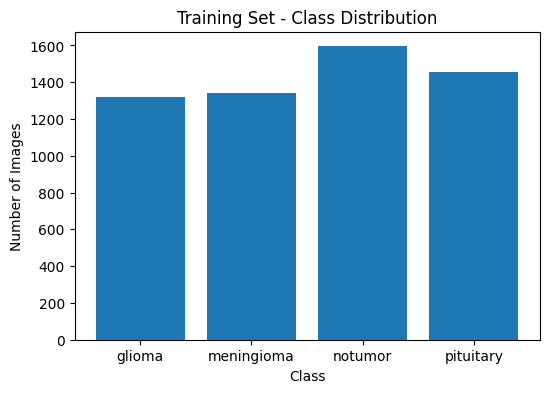

In [11]:
# Train + Test sınıf sayıları

plt.figure(figsize=(6,4))
plt.bar(train_counts.keys(), train_counts.values())
plt.title("Training Set - Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

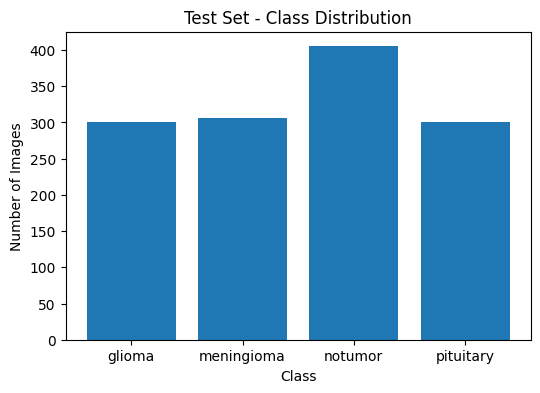

In [12]:
plt.figure(figsize=(6,4))
plt.bar(test_counts.keys(), test_counts.values())
plt.title("Test Set - Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()


### CNN MODELİ

In [13]:
model = Sequential()

model = Sequential([
    Input(shape=(224, 224, 3)),
    
    # İlk katman: Filtre sayısını 32'den 64'e çıkardık
    Conv2D(64, (3, 3), activation='relu'), 
    MaxPooling2D(2, 2),
    
    # İkinci katman: Filtre sayısını 64'ten 128'e çıkardık
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    # Üçüncü bir katman eklemek detayları yakalamak için iyi olabilir (Opsiyonel)
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    
    Flatten(),
    
    # Karar katmanı
    Dense(128, activation='relu'),
    
    # --- YENİ: Dropout Katmanı ---
    # Eğitim sırasında nöronların %50'sini rastgele kapatır, ezberlemeyi önler.
    Dropout(0.5), 
    
    Dense(4, activation='softmax')
])

I0000 00:00:1768312578.404457      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1768312578.408489      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [14]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,299,460 (43.10 MB)

 Trainable params: 11,299,460 (43.10 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
#Eğitim Adımı
# 'epochs=10' modelin veri setini 10 kez baştan sonra okuyacağı anlamına gelir

history = model.fit(train_generator,validation_data=validation_generator,epochs=10)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1768312583.859405     297 service.cc:152] XLA service 0x7a95f00049a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768312583.859439     297 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1768312583.859442     297 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1768312584.392700     297 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-01-13 13:56:28.902501: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-13 13:56:29.074970: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


  2/143 ━━━━━━━━━━━━━━━━━━━━ 14s 100ms/step - accuracy: 0.1953 - loss: 1.5521

I0000 00:00:1768312593.669761     297 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


113/143 ━━━━━━━━━━━━━━━━━━━━ 16s 557ms/step - accuracy: 0.5514 - loss: 0.9960

2026-01-13 13:57:39.783100: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-01-13 13:57:39.955328: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


143/143 ━━━━━━━━━━━━━━━━━━━━ 123s 780ms/step - accuracy: 0.5794 - loss: 0.9462 - val_accuracy: 0.6564 - val_loss: 0.8622
Epoch 2/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 496ms/step - accuracy: 0.7844 - loss: 0.5313 - val_accuracy: 0.7616 - val_loss: 0.6351
Epoch 3/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 72s 501ms/step - accuracy: 0.8239 - loss: 0.4471 - val_accuracy: 0.7686 - val_loss: 0.6469
Epoch 4/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 496ms/step - accuracy: 0.8363 - loss: 0.4042 - val_accuracy: 0.8072 - val_loss: 0.6786
Epoch 5/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 70s 490ms/step - accuracy: 0.8739 - loss: 0.3291 - val_accuracy: 0.8028 - val_loss: 0.5969
Epoch 6/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 493ms/step - accuracy: 0.8851 - loss: 0.2821 - val_accuracy: 0.8212 - val_loss: 0.4879
Epoch 7/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 497ms/step - accuracy: 0.8901 - loss: 0.2751 - val_accuracy: 0.8124 - val_loss: 0.4988
Epoch 8/10
143/143 ━━━━━━━━━━━━━━━━━━━━ 71s 494ms/step - accuracy: 0.9005 - loss: 0.2555 - va

## Model Başarı Ölçümü

### Temel Başarı Metrikleri
* *Accuracy(Doğruluk):* Toplam tahminler içinde doğru olanların oranı.Dengesiz veri setlerinde yanıltıcı olabilir.
*  *Precision(Kesinlik)* : Tümör olarak tahmin edilenlerin kaçı gerçekten tümör
*  *Recall(Duyarlılık)* : Tıpta en önemli metrik budur.Gerçekten tümor olan hastaların kaçta kaçı yakalandı?
*  *F1-Score:* Precision ve Recall değerlerinin dengeli bir ortalamasıdır. Modelin genel kalitesini gösteren en dürüst değerdir.

### AUC-ROC Eğrisi 
* Modelin sınıfları birbirinden ayırt etme gücünü temsil eder. Alan(AUC) 1.0'a ne kadar yakınsa modelin tümörlü ve tümörsüz dokuyu ayırma yeteneği o kadar mükemmeldir.

In [16]:
test_generator.reset() # sırayı garantilemek için jeneratörü sıfırla
y_pred = model.predict(test_generator)
y_pred_classes = y_pred.argmax(axis=1)
y_true = test_generator.classes

print(confusion_matrix(y_true, y_pred_classes))
print(classification_report(y_true, y_pred_classes))

41/41 ━━━━━━━━━━━━━━━━━━━━ 15s 357ms/step
[[238  61   0   1]
 [ 12 208  64  22]
 [  4   5 395   1]
 [  1  10   0 289]]
              precision    recall  f1-score   support

           0       0.93      0.79      0.86       300
           1       0.73      0.68      0.71       306
           2       0.86      0.98      0.91       405
           3       0.92      0.96      0.94       300

    accuracy                           0.86      1311
   macro avg       0.86      0.85      0.85      1311
weighted avg       0.86      0.86      0.86      1311



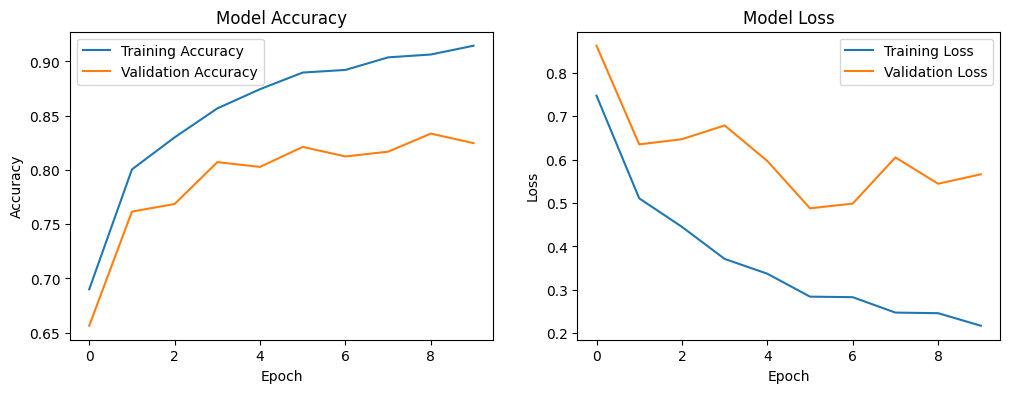

In [17]:
# 1. Doğruluk (Accuracy) Grafiği
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# 2. Kayıp (Loss) Grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()